In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib.backends.backend_pdf import PdfPages
from functools import partial, reduce
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import os
import re
import glob

In [2]:
all_files = glob.glob('C:/Users/lzoeckler/Desktop/all_data/separated/binned/*.csv')
big_df = []
for file in all_files:
    df = pd.read_csv(file)
    big_df.append(df)
big_df = pd.concat(big_df, sort=True)
big_df = big_df.loc[~big_df['PCR_pos'].isnull()]
big_df.head()

,HRP2_deletion,PCR_pos,age_yrs,coinfection,country,febrile,infection_category,lat,long,microscopy_pos,...,quansys_LDH_Pf_result,quansys_LDH_Pv_bin,quansys_LDH_Pv_pg_ml,quansys_LDH_Pv_result,quansys_type,sample_id,sample_type,study_id,survey,timepoint_days
0,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 110501023 (),WB,16-SMRU-01,cross sectional ...,NaN
1,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1421001 (),WB,16-SMRU-01,cross sectional ...,NaN
2,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1421035 (),WB,16-SMRU-01,cross sectional ...,NaN
3,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 151019 (),WB,16-SMRU-01,cross sectional ...,NaN
4,NaN,0.0,NaN,0.0,Myanmar ...,0.0,chronic ...,NaN,NaN,NaN,...,NaN,0.0,< 2.33,0.0,4plex,1 1771028 (),WB,16-SMRU-01,cross sectional ...,NaN


In [3]:
for study_id in big_df['study_id'].unique():
    study_df = big_df.loc[big_df['study_id'] == study_id]
    print(study_id, len(study_df))

16-SMRU-01 1822
17-NIH-01 620
17-NIH-02 327
17-QIMR-01 305
17-QIMR-02 163
17-QIMR-03 22
18-DLS-01 75
18-DLS-02 2
18-FIND-01 94
18-FIND-02 25


In [4]:
len(big_df)

3455

In [5]:
def clean_strings(val):
    if isinstance(val, str):
        if '<' in val:
            return np.log10(.1)
        elif '>' in val:
            clean = val.replace('> ', '')
            return np.log10(float(clean) + .1)
        else:
            try:
                return np.log10(float(val) + .1)
            except ValueError:
                return np.null
    elif isinstance(val, float) or isinstance(val, int):
        return np.log10(val + .1)
    else:
        raise

In [6]:
val_cols = ['quansys_HRP2_pg_ml', 'quansys_LDH_Pan_pg_ml', 'quansys_LDH_Pv_pg_ml',
            'quansys_LDH_Pf_pg_ml', 'quansys_CRP_ng_ml']

In [7]:
"""Which datasets are contributing the bulk of samples? Guessing Myanmar is one

Can we make subplots for the 2-4 datasets that contribute the most samples?
17-NIH-01 620
17-NIH-02 327
17-QIMR-01 305"""


'Which datasets are contributing the bulk of samples? Guessing Myanmar is one\n\nCan we make subplots for the 2-4 datasets that contribute the most samples?\n17-NIH-01 620\n17-NIH-02 327\n17-QIMR-01 305'

In [8]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
test_df = pos_df.copy(deep=True)
test_df = test_df[val_cols + ['PCR_pos', 'sample_id']]
test_df = test_df.loc[~test_df['quansys_LDH_Pv_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df[val_cols] = test_df[val_cols].applymap(clean_strings)
x = test_df['quansys_LDH_Pan_pg_ml'].values
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
10,-1.000000,2.382557,1.654658,NaN,1.445823,1.0,1 26831051 ()
12,3.648414,3.406799,-1.000000,NaN,2.477490,1.0,1 2751037 ()
18,-1.000000,2.184635,1.618884,NaN,1.889668,1.0,1 3201006 ()
21,-1.000000,3.318706,1.806858,NaN,2.064804,1.0,1 3391021 ()
22,-1.000000,2.247581,-1.000000,NaN,2.338987,1.0,1 3421021 ()


In [9]:
sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(2000)]
sub_samps = sub['sample_id'].values
len(sub)

107

In [10]:
below = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)]
len(below)

871

In [11]:
len(test_df)

1477

In [12]:
107/1477

0.07244414353419093

In [13]:
871/1477

0.5897088693297224

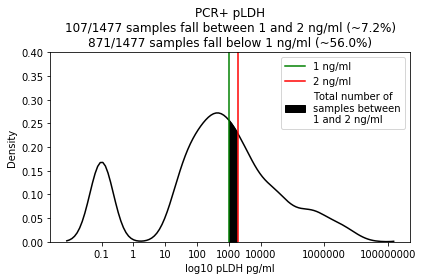

In [14]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/density_plot.pdf')
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(np.log10(2000) > x1) & (x1 > np.log10(900)), color='k', label='Total number of\nsamples between\n1 and 2 ng/ml')
ax.axvline(np.log10(1000), color='g', label='1 ng/ml')#, ymax=0.5)
ax.axvline(np.log10(2000), color='r', label='2 ng/ml')#, ymax=0.5)
ax.set_ylim(0, 0.4)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('log10 pLDH pg/ml')
plt.xticks([-1, 0, 1, 2, 3, 4, 6, 8], [0.1, 1, 10, 100, 1000, 10000, 1000000, 100000000])
f = ax.get_figure()
plt.title('PCR+ pLDH\n107/1477 samples fall between 1 and 2 ng/ml (~7.2%)\n871/1477 samples fall below 1 ng/ml (~56.0%)')
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()

In [15]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
myan_df = pos_df.loc[pos_df['study_id'] == '16-SMRU-01']
test_df = myan_df.copy(deep=True)
test_df = test_df[val_cols + ['PCR_pos', 'sample_id']]
test_df = test_df.loc[~test_df['quansys_LDH_Pv_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df[val_cols] = test_df[val_cols].applymap(clean_strings)
x = test_df['quansys_LDH_Pan_pg_ml'].values
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
10,-1.000000,2.382557,1.654658,NaN,1.445823,1.0,1 26831051 ()
12,3.648414,3.406799,-1.000000,NaN,2.477490,1.0,1 2751037 ()
18,-1.000000,2.184635,1.618884,NaN,1.889668,1.0,1 3201006 ()
21,-1.000000,3.318706,1.806858,NaN,2.064804,1.0,1 3391021 ()
22,-1.000000,2.247581,-1.000000,NaN,2.338987,1.0,1 3421021 ()


In [16]:
sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(2000)]
sub_samps = sub['sample_id'].values
len(sub)

53

In [17]:
below = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)]
len(below)

414

In [18]:
len(test_df)

635

In [19]:
53/635

0.08346456692913386

In [20]:
414/635

0.6519685039370079

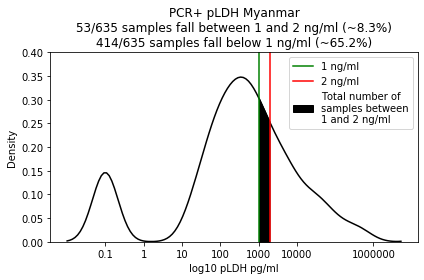

In [21]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/myan_density_plot.pdf')
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(np.log10(2000) > x1) & (x1 > np.log10(900)), color='k', label='Total number of\nsamples between\n1 and 2 ng/ml')
ax.axvline(np.log10(1000), color='g', label='1 ng/ml')#, ymax=0.5)
ax.axvline(np.log10(2000), color='r', label='2 ng/ml')#, ymax=0.5)
ax.set_ylim(0, 0.4)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('log10 pLDH pg/ml')
plt.xticks([-1, 0, 1, 2, 3, 4, 6], [0.1, 1, 10, 100, 1000, 10000, 1000000])
f = ax.get_figure()
plt.title('PCR+ pLDH Myanmar\n53/635 samples fall between 1 and 2 ng/ml (~8.3%)\n414/635 samples fall below 1 ng/ml (~65.2%)')
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()

In [22]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
pf_df = pos_df.loc[pos_df['pf'] == 1]
test_df = pf_df.copy(deep=True)
test_df = test_df[val_cols + ['PCR_pos', 'sample_id']]
test_df = test_df.loc[~test_df['quansys_LDH_Pv_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df[val_cols] = test_df[val_cols].applymap(clean_strings)
x = test_df['quansys_LDH_Pan_pg_ml'].values
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
12,3.648414,3.406799,-1.000000,NaN,2.477490,1.0,1 2751037 ()
21,-1.000000,3.318706,1.806858,NaN,2.064804,1.0,1 3391021 ()
26,1.522835,1.716421,-1.000000,NaN,3.082272,1.0,1 3501016 ()
27,0.715167,3.038866,1.837083,NaN,3.124379,1.0,1 3571005 ()
28,0.431364,1.710456,0.627366,NaN,3.003681,1.0,1 3571039 ()


In [23]:
sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(2000)]
sub_samps = sub['sample_id'].values
len(sub)

46

In [24]:
below = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)]
len(below)

509

In [25]:
len(test_df)

802

In [26]:
46/802

0.057356608478802994

In [27]:
509/802

0.6346633416458853

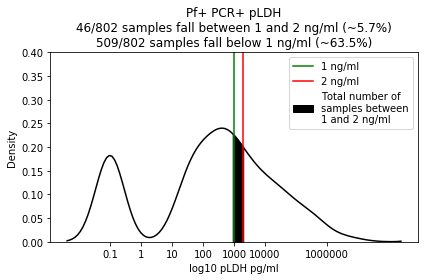

In [28]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/pf_density_plot.pdf')
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(np.log10(2000) > x1) & (x1 > np.log10(900)), color='k', label='Total number of\nsamples between\n1 and 2 ng/ml')
ax.axvline(np.log10(1000), color='g', label='1 ng/ml')#, ymax=0.5)
ax.axvline(np.log10(2000), color='r', label='2 ng/ml')#, ymax=0.5)
ax.set_ylim(0, 0.4)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('log10 pLDH pg/ml')
plt.xticks([-1, 0, 1, 2, 3, 4, 6], [0.1, 1, 10, 100, 1000, 10000, 1000000])
f = ax.get_figure()
plt.title('Pf+ PCR+ pLDH\n46/802 samples fall between 1 and 2 ng/ml (~5.7%)\n509/802 samples fall below 1 ng/ml (~63.5%)')
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()

In [29]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
pv_df = pos_df.loc[pos_df['pv'] == 1]
test_df = pv_df.copy(deep=True)
test_df = test_df[val_cols + ['PCR_pos', 'sample_id']]
test_df = test_df.loc[~test_df['quansys_LDH_Pv_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df[val_cols] = test_df[val_cols].applymap(clean_strings)
x = test_df['quansys_LDH_Pan_pg_ml'].values
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
10,-1.000000,2.382557,1.654658,NaN,1.445823,1.0,1 26831051 ()
21,-1.000000,3.318706,1.806858,NaN,2.064804,1.0,1 3391021 ()
31,-1.000000,2.707246,2.097084,NaN,1.964025,1.0,1 3611044 ()
32,-1.000000,2.626443,-1.000000,NaN,2.445625,1.0,1 36311031 ()
36,1.190892,1.784689,-1.000000,NaN,3.086740,1.0,1 36351030 ()


In [30]:
sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(2000)]
sub_samps = sub['sample_id'].values
len(sub)

56

In [31]:
below = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)]
len(below)

251

In [32]:
len(test_df)

596

In [33]:
56/596

0.09395973154362416

In [34]:
251/596

0.4211409395973154

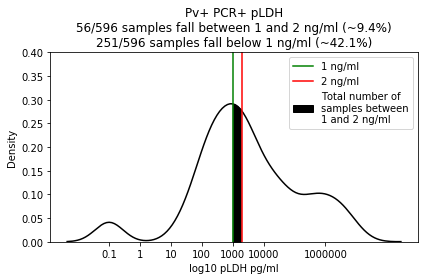

In [35]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/pv_density_plot.pdf')
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(np.log10(2000) > x1) & (x1 > np.log10(900)), color='k', label='Total number of\nsamples between\n1 and 2 ng/ml')
ax.axvline(np.log10(1000), color='g', label='1 ng/ml')#, ymax=0.5)
ax.axvline(np.log10(2000), color='r', label='2 ng/ml')#, ymax=0.5)
ax.set_ylim(0, 0.4)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('log10 pLDH pg/ml')
plt.xticks([-1, 0, 1, 2, 3, 4, 6], [0.1, 1, 10, 100, 1000, 10000, 1000000])
f = ax.get_figure()
plt.title('Pv+ PCR+ pLDH\n56/596 samples fall between 1 and 2 ng/ml (~9.4%)\n251/596 samples fall below 1 ng/ml (~42.1%)')
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()

In [36]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
NIH_01_df = pos_df.loc[pos_df['study_id'] == '17-NIH-01']
test_df = NIH_01_df.copy(deep=True)
test_df = test_df[val_cols + ['PCR_pos', 'sample_id']]
test_df = test_df.loc[~test_df['quansys_LDH_Pv_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df[val_cols] = test_df[val_cols].applymap(clean_strings)
x = test_df['quansys_LDH_Pan_pg_ml'].values
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
17,4.156454,4.547260,0.792987,NaN,2.682798,1.0,1 MV-15-444-E D547 ()
27,3.789929,2.191311,0.550045,NaN,1.940873,1.0,10 444-E D568 ()
38,-1.000000,-1.000000,-1.000000,NaN,-1.000000,1.0,11 322-T D582 ()
42,4.128456,3.974204,0.856203,NaN,2.951730,1.0,11 389-X D568 ()
47,4.217487,4.173392,0.518461,NaN,3.417125,1.0,11 463-V D554 ()


In [37]:
sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(2000)]
sub_samps = sub['sample_id'].values
len(sub)

7

In [38]:
below = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)]
len(below)

54

In [39]:
len(test_df)

125

In [40]:
7/125

0.056

In [41]:
54/125

0.432

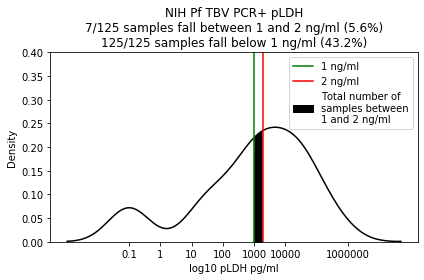

In [42]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/NIH_01_density_plot.pdf')
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(np.log10(2000) > x1) & (x1 > np.log10(900)), color='k', label='Total number of\nsamples between\n1 and 2 ng/ml')
ax.axvline(np.log10(1000), color='g', label='1 ng/ml')#, ymax=0.5)
ax.axvline(np.log10(2000), color='r', label='2 ng/ml')#, ymax=0.5)
ax.set_ylim(0, 0.4)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('log10 pLDH pg/ml')
plt.xticks([-1, 0, 1, 2, 3, 4, 6], [0.1, 1, 10, 100, 1000, 10000, 1000000])
f = ax.get_figure()
plt.title('NIH Pf TBV PCR+ pLDH\n7/125 samples fall between 1 and 2 ng/ml (5.6%)\n125/125 samples fall below 1 ng/ml (43.2%)')
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()

In [43]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
feb_df = pos_df.loc[pos_df['febrile'] == 1]
test_df = feb_df.copy(deep=True)
test_df = test_df[val_cols + ['PCR_pos', 'sample_id']]
test_df = test_df.loc[~test_df['quansys_LDH_Pan_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df[val_cols] = test_df[val_cols].applymap(clean_strings)
x = test_df['quansys_LDH_Pan_pg_ml'].values
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
86,3.804619,3.973994,1.132900,NaN,2.995130,1.0,10 3611019 ()
90,4.217487,4.630735,3.061622,NaN,1.709069,1.0,10 36341034 ()
115,3.591910,3.991607,3.975803,NaN,2.660987,1.0,11 2211003 ()
196,3.367522,3.155461,1.205204,NaN,3.514161,1.0,12 36341002 ()
233,4.217487,3.852183,-1.000000,NaN,3.479332,1.0,13 3201018 ()


In [44]:
sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(2000)]
sub_samps = sub['sample_id'].values
len(sub)

5

In [45]:
below = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)]
len(below)

8

In [46]:
len(test_df)

131

In [47]:
5/131

0.03816793893129771

In [48]:
8/131

0.061068702290076333

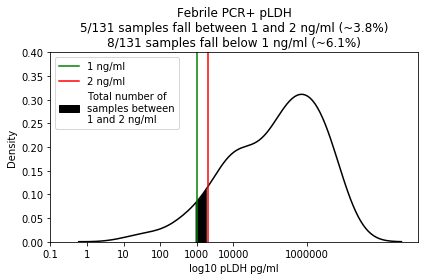

In [49]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/febrile_density_plot.pdf')
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(np.log10(2000) > x1) & (x1 > np.log10(900)), color='k', label='Total number of\nsamples between\n1 and 2 ng/ml')
ax.axvline(np.log10(1000), color='g', label='1 ng/ml')#, ymax=0.5)
ax.axvline(np.log10(2000), color='r', label='2 ng/ml')#, ymax=0.5)
ax.set_ylim(0, 0.4)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('log10 pLDH pg/ml')
plt.xticks([-1, 0, 1, 2, 3, 4, 6], [0.1, 1, 10, 100, 1000, 10000, 1000000])
f = ax.get_figure()
plt.title('Febrile PCR+ pLDH\n5/131 samples fall between 1 and 2 ng/ml (~3.8%)\n8/131 samples fall below 1 ng/ml (~6.1%)')
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()

In [50]:
pos_df = big_df.loc[big_df['PCR_pos'] == 1]
non_feb_df = pos_df.loc[pos_df['febrile'] == 0]
test_df = non_feb_df.copy(deep=True)
test_df = test_df[val_cols + ['PCR_pos', 'sample_id']]
test_df = test_df.loc[~test_df['quansys_LDH_Pan_pg_ml'].isnull()]
test_df = test_df.loc[~test_df['quansys_HRP2_pg_ml'].isnull()]
test_df[val_cols] = test_df[val_cols].applymap(clean_strings)
x = test_df['quansys_LDH_Pan_pg_ml'].values
test_df.head()

,quansys_HRP2_pg_ml,quansys_LDH_Pan_pg_ml,quansys_LDH_Pv_pg_ml,quansys_LDH_Pf_pg_ml,quansys_CRP_ng_ml,PCR_pos,sample_id
10,-1.000000,2.382557,1.654658,NaN,1.445823,1.0,1 26831051 ()
12,3.648414,3.406799,-1.000000,NaN,2.477490,1.0,1 2751037 ()
18,-1.000000,2.184635,1.618884,NaN,1.889668,1.0,1 3201006 ()
21,-1.000000,3.318706,1.806858,NaN,2.064804,1.0,1 3391021 ()
22,-1.000000,2.247581,-1.000000,NaN,2.338987,1.0,1 3421021 ()


In [51]:
sub = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] > np.log10(1000)]
sub = sub.loc[sub['quansys_LDH_Pan_pg_ml'] < np.log10(2000)]
sub_samps = sub['sample_id'].values
len(sub)

48

In [52]:
below = test_df.loc[test_df['quansys_LDH_Pan_pg_ml'] < np.log10(1000)]
below = below['sample_id'].values
len(below)

408

In [53]:
len(test_df)

595

In [54]:
48/595

0.08067226890756303

In [55]:
408/595

0.6857142857142857

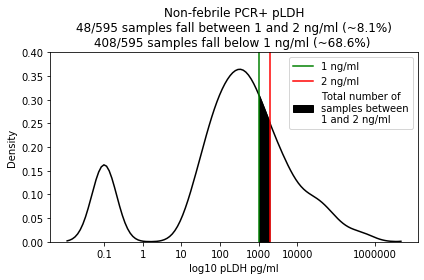

In [56]:
pp = PdfPages('C:/Users/lzoeckler/Desktop/non_febrile_density_plot.pdf')
ax = sns.distplot(x, hist=False, color='k')
ln = ax.lines[0]
y = ln.get_ydata()
x1 = ln.get_xdata()
ax.fill_between(x1, 0, y, where=(np.log10(2000) > x1) & (x1 > np.log10(900)), color='k', label='Total number of\nsamples between\n1 and 2 ng/ml')
ax.axvline(np.log10(1000), color='g', label='1 ng/ml')#, ymax=0.5)
ax.axvline(np.log10(2000), color='r', label='2 ng/ml')#, ymax=0.5)
ax.set_ylim(0, 0.4)
ax.legend()
ax.set_ylabel('Density')
ax.set_xlabel('log10 pLDH pg/ml')
plt.xticks([-1, 0, 1, 2, 3, 4, 6], [0.1, 1, 10, 100, 1000, 10000, 1000000])
f = ax.get_figure()
plt.title('Non-febrile PCR+ pLDH\n48/595 samples fall between 1 and 2 ng/ml (~8.1%)\n408/595 samples fall below 1 ng/ml (~68.6%) ')
plt.tight_layout()
plt.show()
pp.savefig(f)
plt.close()
pp.close()

In [57]:
from scipy.integrate import simps
from numpy import trapz

In [58]:
area = simps(y, x=x1)
print("area =", area)

area = 0.9999022499716027
